In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import metrics
import os   
import scipy


fig_path = Path("fig_physical")
fig_path.mkdir(exist_ok=True)

torch.manual_seed(420)
np.random.seed(430)
torch.manual_seed(420)
np.random.seed(430)

# Overall settings
out_dir = "out_big_training_ft_strong_rand2"
# System settings
nu = 7
ny = 14

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 5
compile = False 

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high") 
torch.backends.cuda.matmul.allow_tf32 = True 
torch.backends.cudnn.allow_tf32 = True 


In [2]:
model_path = os.path.abspath(f"./{out_dir}")
list_of_available_models = os.listdir(model_path)

print("These are the available models in "+str(model_path) +":\n")
for i in range(len(list_of_available_models)):
    single_pt_file_path = os.path.join(model_path, list_of_available_models[i]) 
    print("--> ",list_of_available_models[i])
available_models = len(list_of_available_models)

# Create out dir
out_dir = Path(out_dir)
model_name = list_of_available_models[int(np.random.randint(0,available_models))]

print(" \n TESTING ON: ", model_name)
exp_data = torch.load(out_dir/model_name, map_location="cuda:0")
cfg = exp_data["cfg"]
seq_len = cfg.seq_len_ctx + cfg.seq_len_new

model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);

These are the available models in /home/manuel/Scrivania/CODE/Transformer_for_isaac/out_big_training_ft_strong_rand2:

-->  ckpt_partition_20_batch16_embd192_heads12_lay12_MSE.pt
 
 TESTING ON:  ckpt_partition_20_batch16_embd192_heads12_lay12_MSE.pt


New Acquisition from Txt files

In [3]:
def load_input(input_file):
    # Load input and output data from files
    input_data = np.loadtxt(input_file)
    # Convert data to PyTorch tensors
    input_tensor = torch.tensor(input_data, dtype=torch.float32, device='cuda:0')
    input_tensor = input_tensor[:,:7] # Pickung only the first 7 (with gravity)
    return input_tensor

def load_output(output_file):
    output_file = np.loadtxt(output_file)
    # Convert data to PyTorch tensors
    output_tensor = torch.tensor(output_file, dtype=torch.float32, device='cuda:0')
    joint_position = output_tensor[:,:7] # 
    EE_pose = output_tensor[:,7:]
    output_tensor=torch.cat((EE_pose,joint_position),dim=1)
    return output_tensor

def moving_average(data, window_size):
    """Compute the moving average of data with a given window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Real Robot input:
input_file = "./Physical_trajectories/input_120Hz_FC1_magnified.txt"
input_tensor = load_input(input_file)

# Real Robot output:
output_file = "./Physical_trajectories/output_120Hz_FC1_magnified.txt"
output_tensor = load_output(output_file)

print(input_tensor.shape)
print(output_tensor.shape)

torch.Size([17285, 7])
torch.Size([17285, 14])


In [4]:
resample = 3000
sample = 60

In [5]:
input_tensor_sampled = input_tensor[::sample]
output_tensor_sampled = output_tensor[::sample]

input_tensor_sampled_scipy = scipy.signal.resample(input_tensor_sampled.cpu().numpy(),resample,axis=0)
output_tensor_sampled_scipy = scipy.signal.resample(output_tensor_sampled.cpu().numpy(),resample,axis=0)

<Figure size 640x480 with 0 Axes>

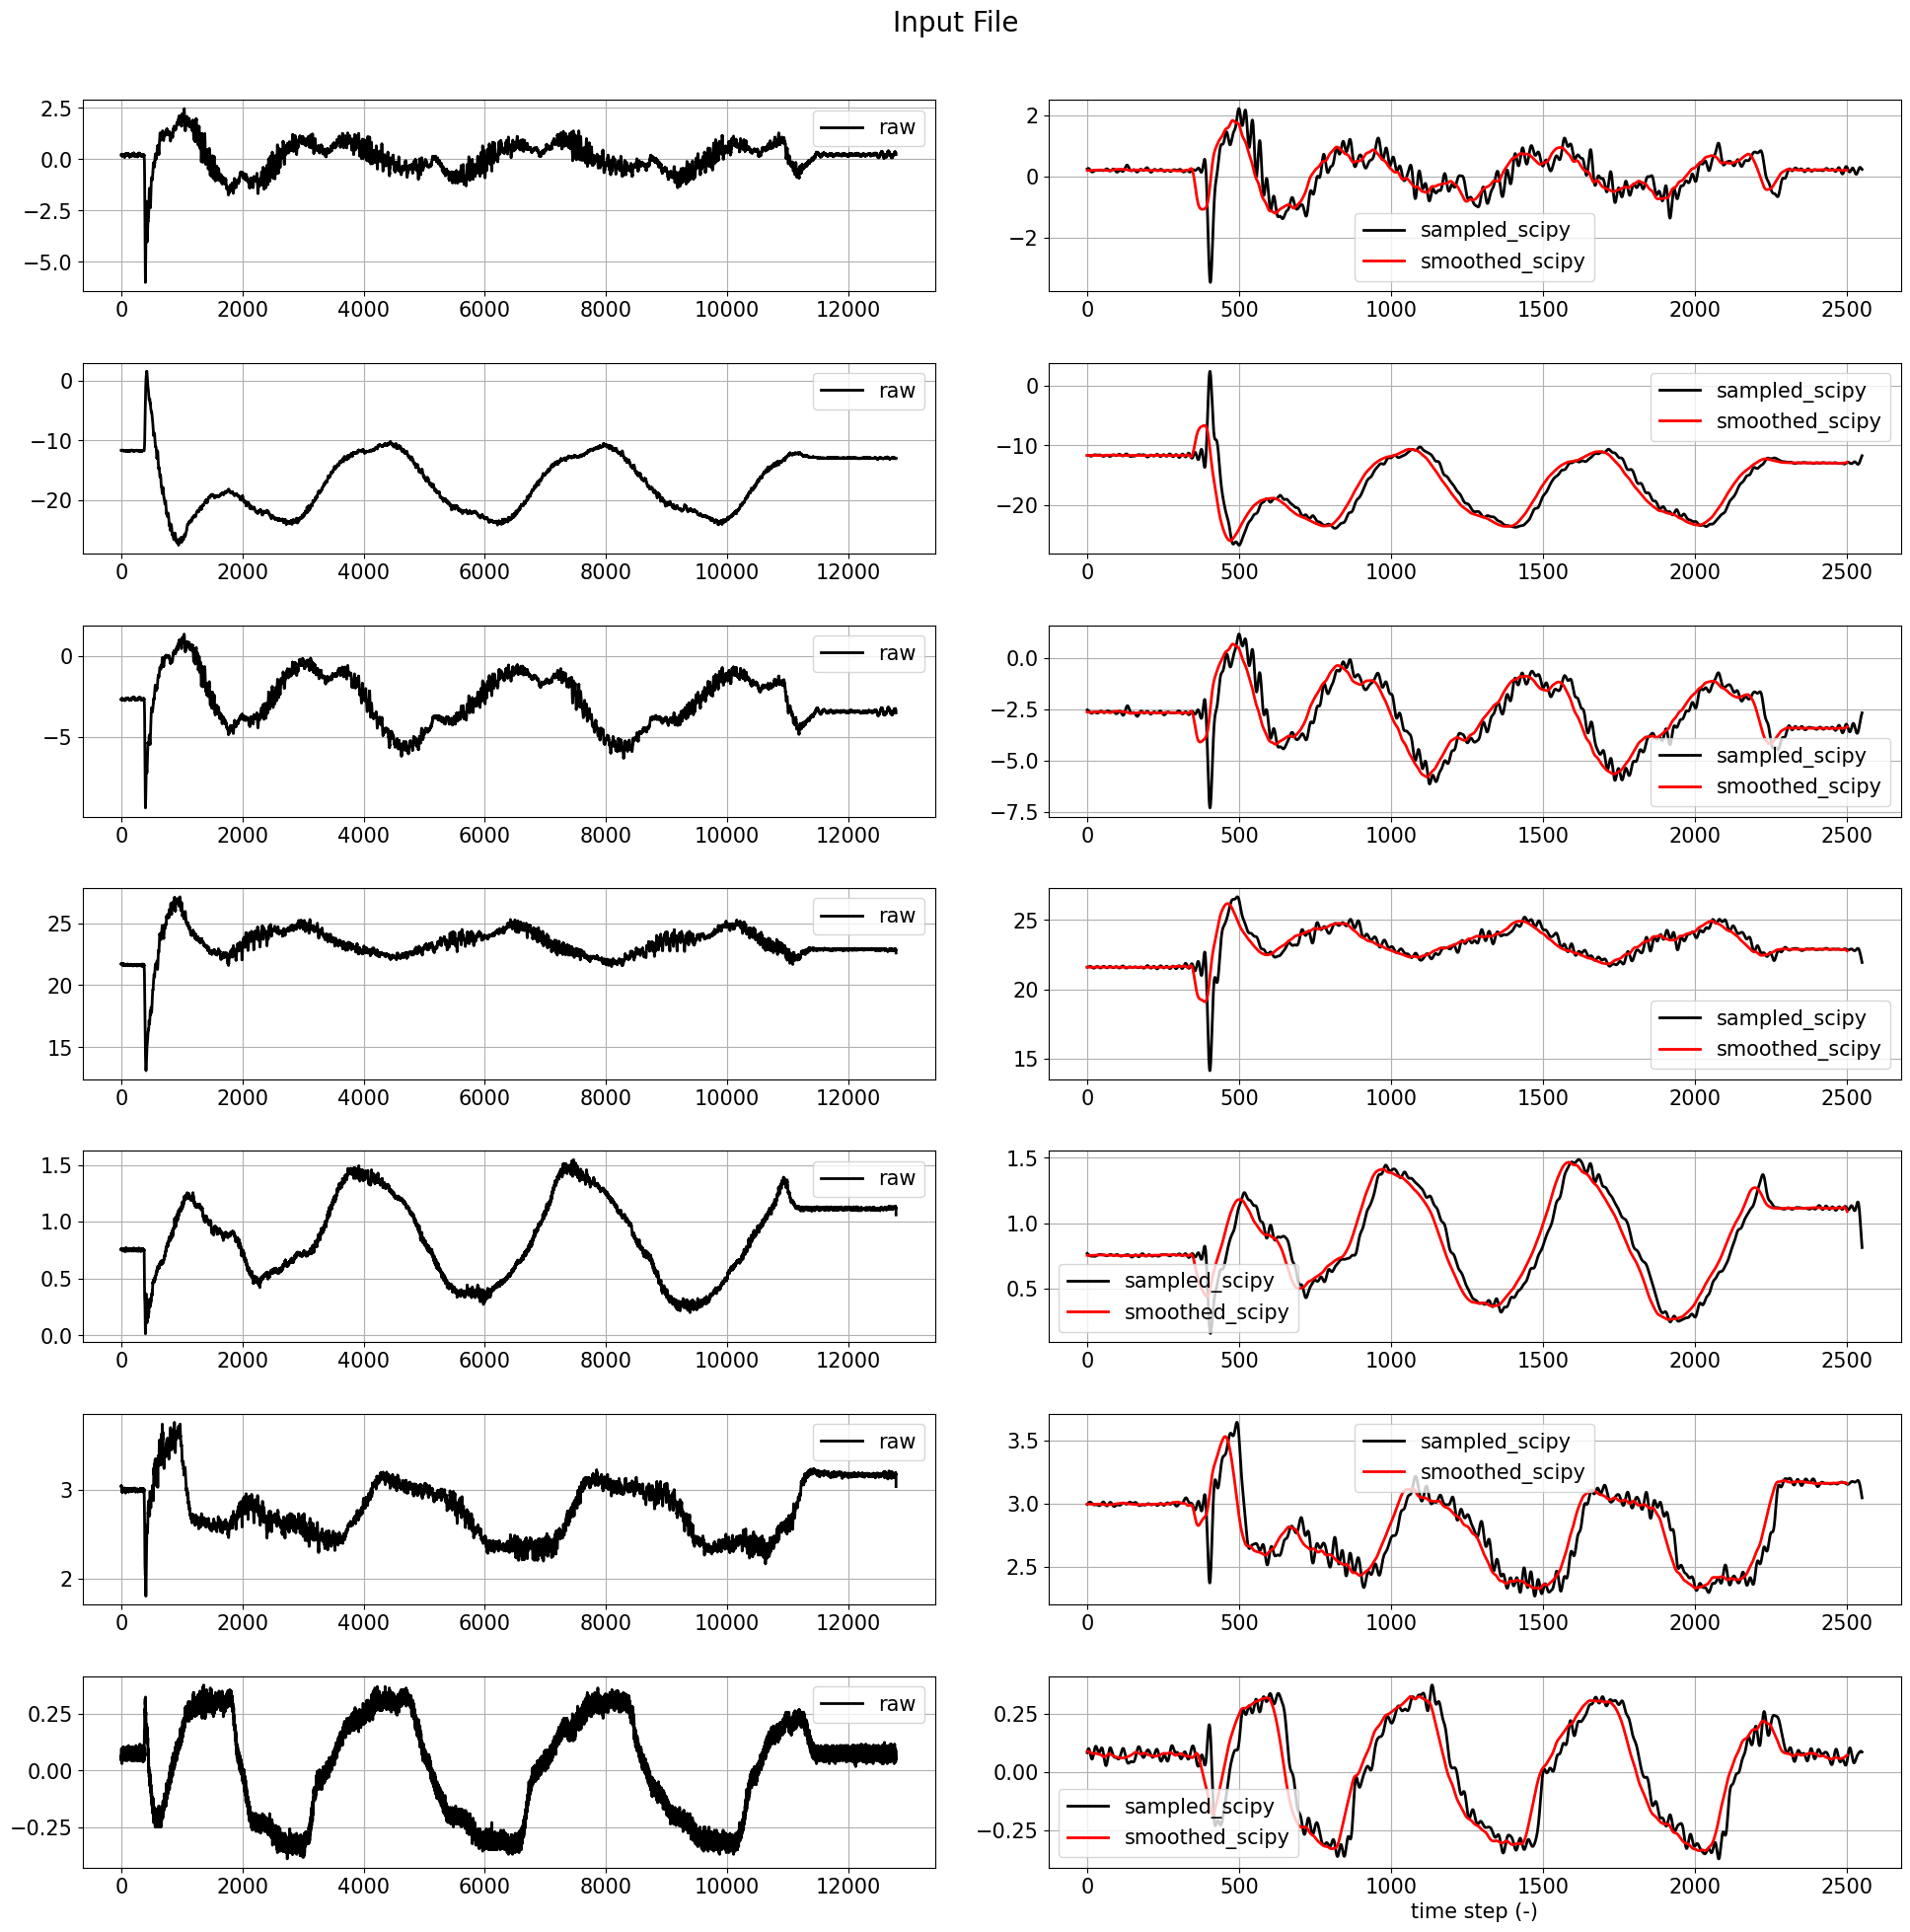

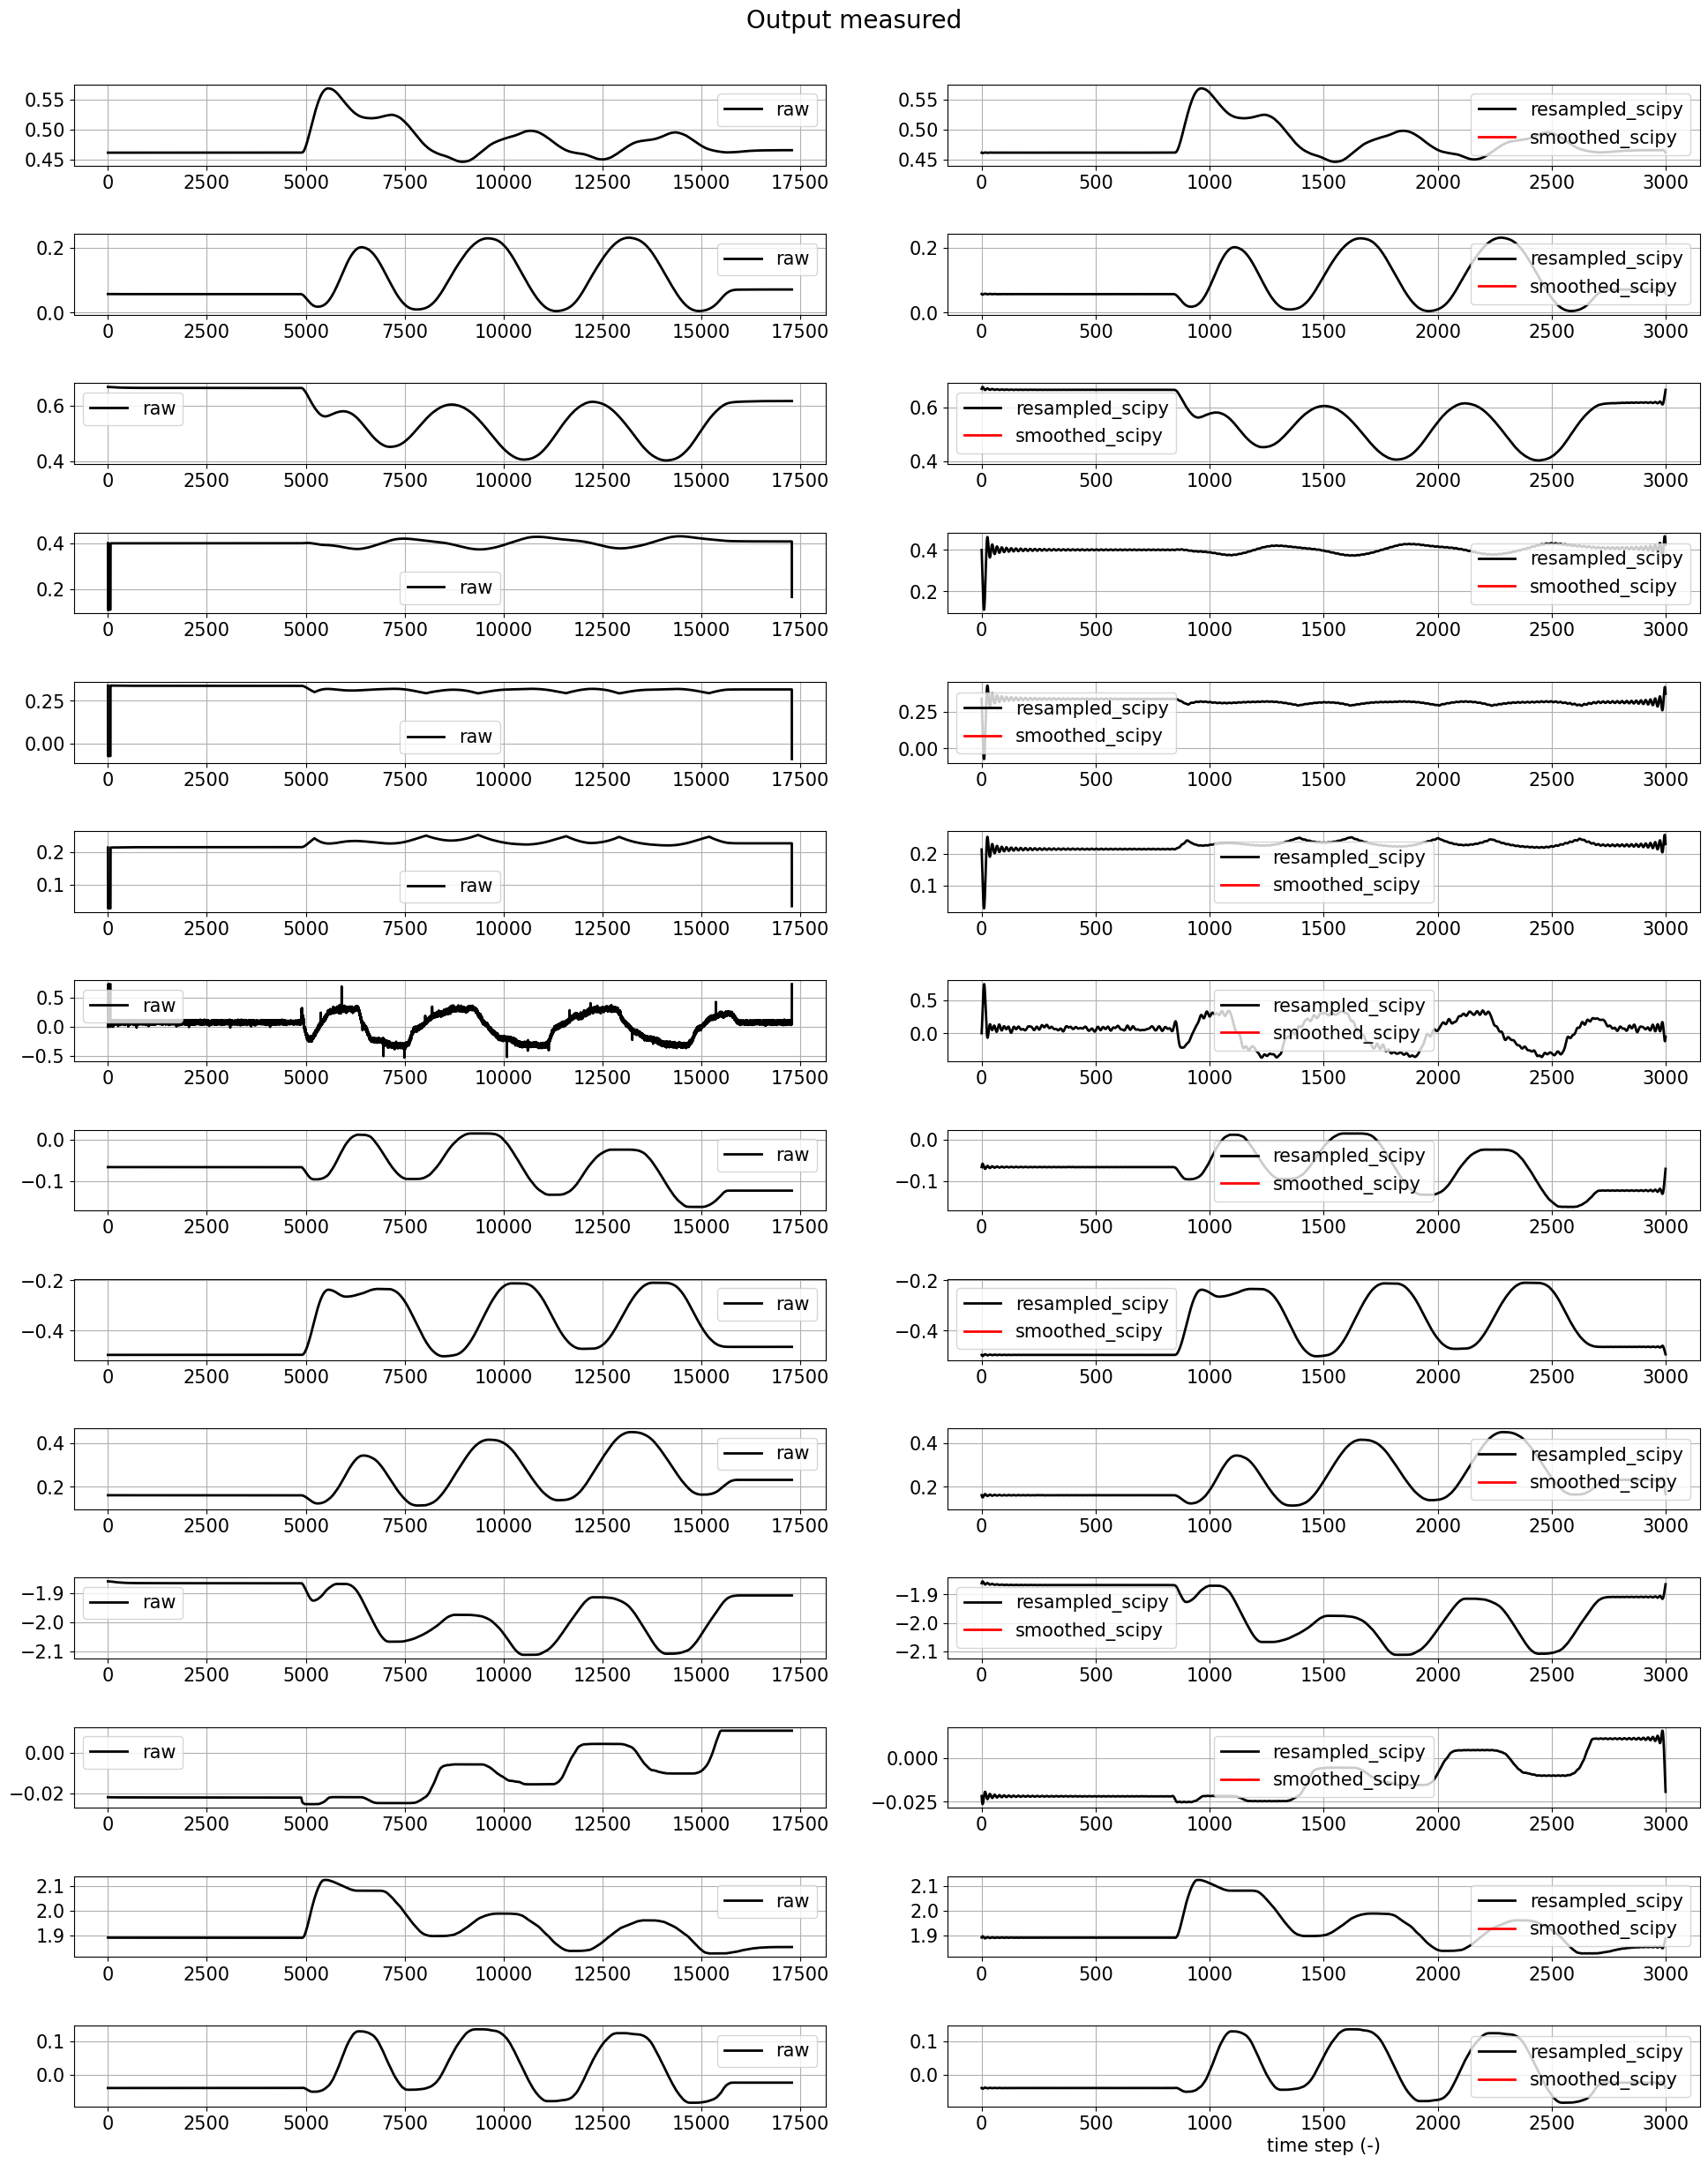

In [6]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.tight_layout( pad = 2)

t = np.arange(0,input_tensor.shape[0])

fig, axs = plt.subplots(int(nu),2, figsize=(20, 20))
fig.suptitle('Input File',size = 20,y = .99)
k = 0

input_smoothed = np.apply_along_axis(lambda d: moving_average(d, 50), axis=0, arr=input_tensor_sampled_scipy)

# 1khz
# input_smoothed = np.apply_along_axis(lambda d: moving_average(d, 50), axis=0, arr=input_tensor.cpu().numpy()[5100:6149])

for j in range(int(nu)):
    axs[j,0].plot(input_tensor.cpu().numpy()[4500:, k] ,'k',linewidth=2,label="raw")
    axs[j,1].plot(input_tensor_sampled_scipy[450:, k] ,'k',linewidth=2,label="sampled_scipy")
    axs[j,1].plot(input_smoothed[450:,k],'r',linewidth=2,label="smoothed_scipy")
    
    # 1khz circle
    # axs[j,0].plot(input_smoothed[:,k],'r',linewidth=2,label="SMA")

    axs[j,0].grid(True)
    axs[j,1].grid(True)

    axs[j,0].legend()
    axs[j,1].legend()
    k +=1

plt.xlabel("time step (-)")
plt.tight_layout( pad = 2)

fig, axs = plt.subplots(int(ny),2, figsize=(20, 25))
fig.suptitle('Output measured',size = 20,y = .99)
k = 0

output_smoothed = np.apply_along_axis(lambda d: moving_average(d, 50), axis=0, arr=output_tensor_sampled_scipy)

#  1 kHz
# output_smoothed = np.apply_along_axis(lambda d: moving_average(d, 50), axis=0, arr=output_tensor.cpu().numpy()[5100:6149])

for j in range(int(ny)):
    axs[j,0].plot(output_tensor.cpu().numpy()[:, k] ,'k',linewidth=2,label="raw")
    axs[j,1].plot(output_tensor_sampled_scipy[:, k] ,'k',linewidth=2,label="resampled_scipy")
    axs[j,1].plot(output_smoothed[4500:,k],'r',linewidth=2,label="smoothed_scipy")

    # 1khz circle
    # axs[j,0].plot(output_smoothed[:,k],'r',linewidth=2,label="SMA")
    
    axs[j,0].grid(True)
    axs[j,1].grid(True)
    axs[j,0].legend()
    axs[j,1].legend()
    k +=1

plt.xlabel("time step (-)")
plt.tight_layout( pad = 2)


In [10]:
start = 1200

position = output_tensor_sampled_scipy[start:start +seq_len,:] 
control_action = input_tensor_sampled_scipy[start:start +seq_len,:] 

control_action = torch.tensor(control_action,device='cuda:0',dtype=torch.float32)
position = torch.tensor(position,device='cuda:0',dtype=torch.float32)

Sampled scipy

In [11]:
#initializing errors 
y_ground_truth = torch.empty(position[cfg.seq_len_ctx:seq_len,:].shape,device=device)
y_predicted = torch.empty(position[cfg.seq_len_ctx:seq_len,:].shape,device=device)
sim_error = torch.empty(position[cfg.seq_len_ctx:seq_len,:].shape,device=device)

single_u = control_action[:seq_len,:]
single_y = position[:seq_len,:]
single_y = single_y.to(device)
single_u = single_u.to(device)

with torch.no_grad():
    single_y_ctx = single_y[:cfg.seq_len_ctx, :]
    single_u_ctx = single_u[:cfg.seq_len_ctx, :]
    single_y_new = single_y[cfg.seq_len_ctx:seq_len, :]
    single_u_new = single_u[cfg.seq_len_ctx:seq_len, :]
    t_start = time.time()
    single_y_sim = model(single_y_ctx.unsqueeze(0), single_u_ctx.unsqueeze(0), single_u_new.unsqueeze(0))
    t_end = time.time()
    single_sim_error = single_y_sim - single_y_new
    
    y_ground_truth = single_y_new
    y_predicted = single_y_sim
    sim_error = single_sim_error

print("Random required time for single simulation:", t_end-t_start)


t = np.arange(1, single_u_new.shape[0]+1) + cfg.seq_len_ctx
y_ground_truth = y_ground_truth.to("cpu").detach().numpy()
y_predicted = y_predicted.squeeze(0).to("cpu").detach().numpy()
sim_error = sim_error.squeeze(0).to("cpu").detach().numpy()

print(y_ground_truth.shape)
print(y_predicted.shape)
print(sim_error.shape)

rmse = metrics.rmse(y_ground_truth, y_predicted, time_axis=0)
nrmse = metrics.nrmse(y_ground_truth, y_predicted, time_axis=0)
fit_index = metrics.fit_index(y_ground_truth, y_predicted, time_axis=0)
r_squared = metrics.r_squared(y_ground_truth, y_predicted, time_axis=0)

n_param = sum(map(torch.numel, model.parameters()))
print(f'parameter count: {n_param}')
print(f'train_time: {exp_data["train_time"] / 60} minutes')
print(f'rmse: {rmse.mean()}')
print(f'nrmse: {nrmse.mean()}') 
print(f'fit_index: {fit_index.mean()}') 
print(f'r_squared: {r_squared.mean()}') 
print(f'r_squared_std: {r_squared.std()}') 

Random required time for single simulation: 0.012872457504272461
(800, 14)
(800, 14)
(800, 14)
parameter count: 12638222
train_time: 27.464524829387663 minutes
rmse: 0.13619300723075867
nrmse: 6.680024147033691
fit_index: -568.00244140625
r_squared: -129.810791015625
r_squared_std: 244.07815551757812


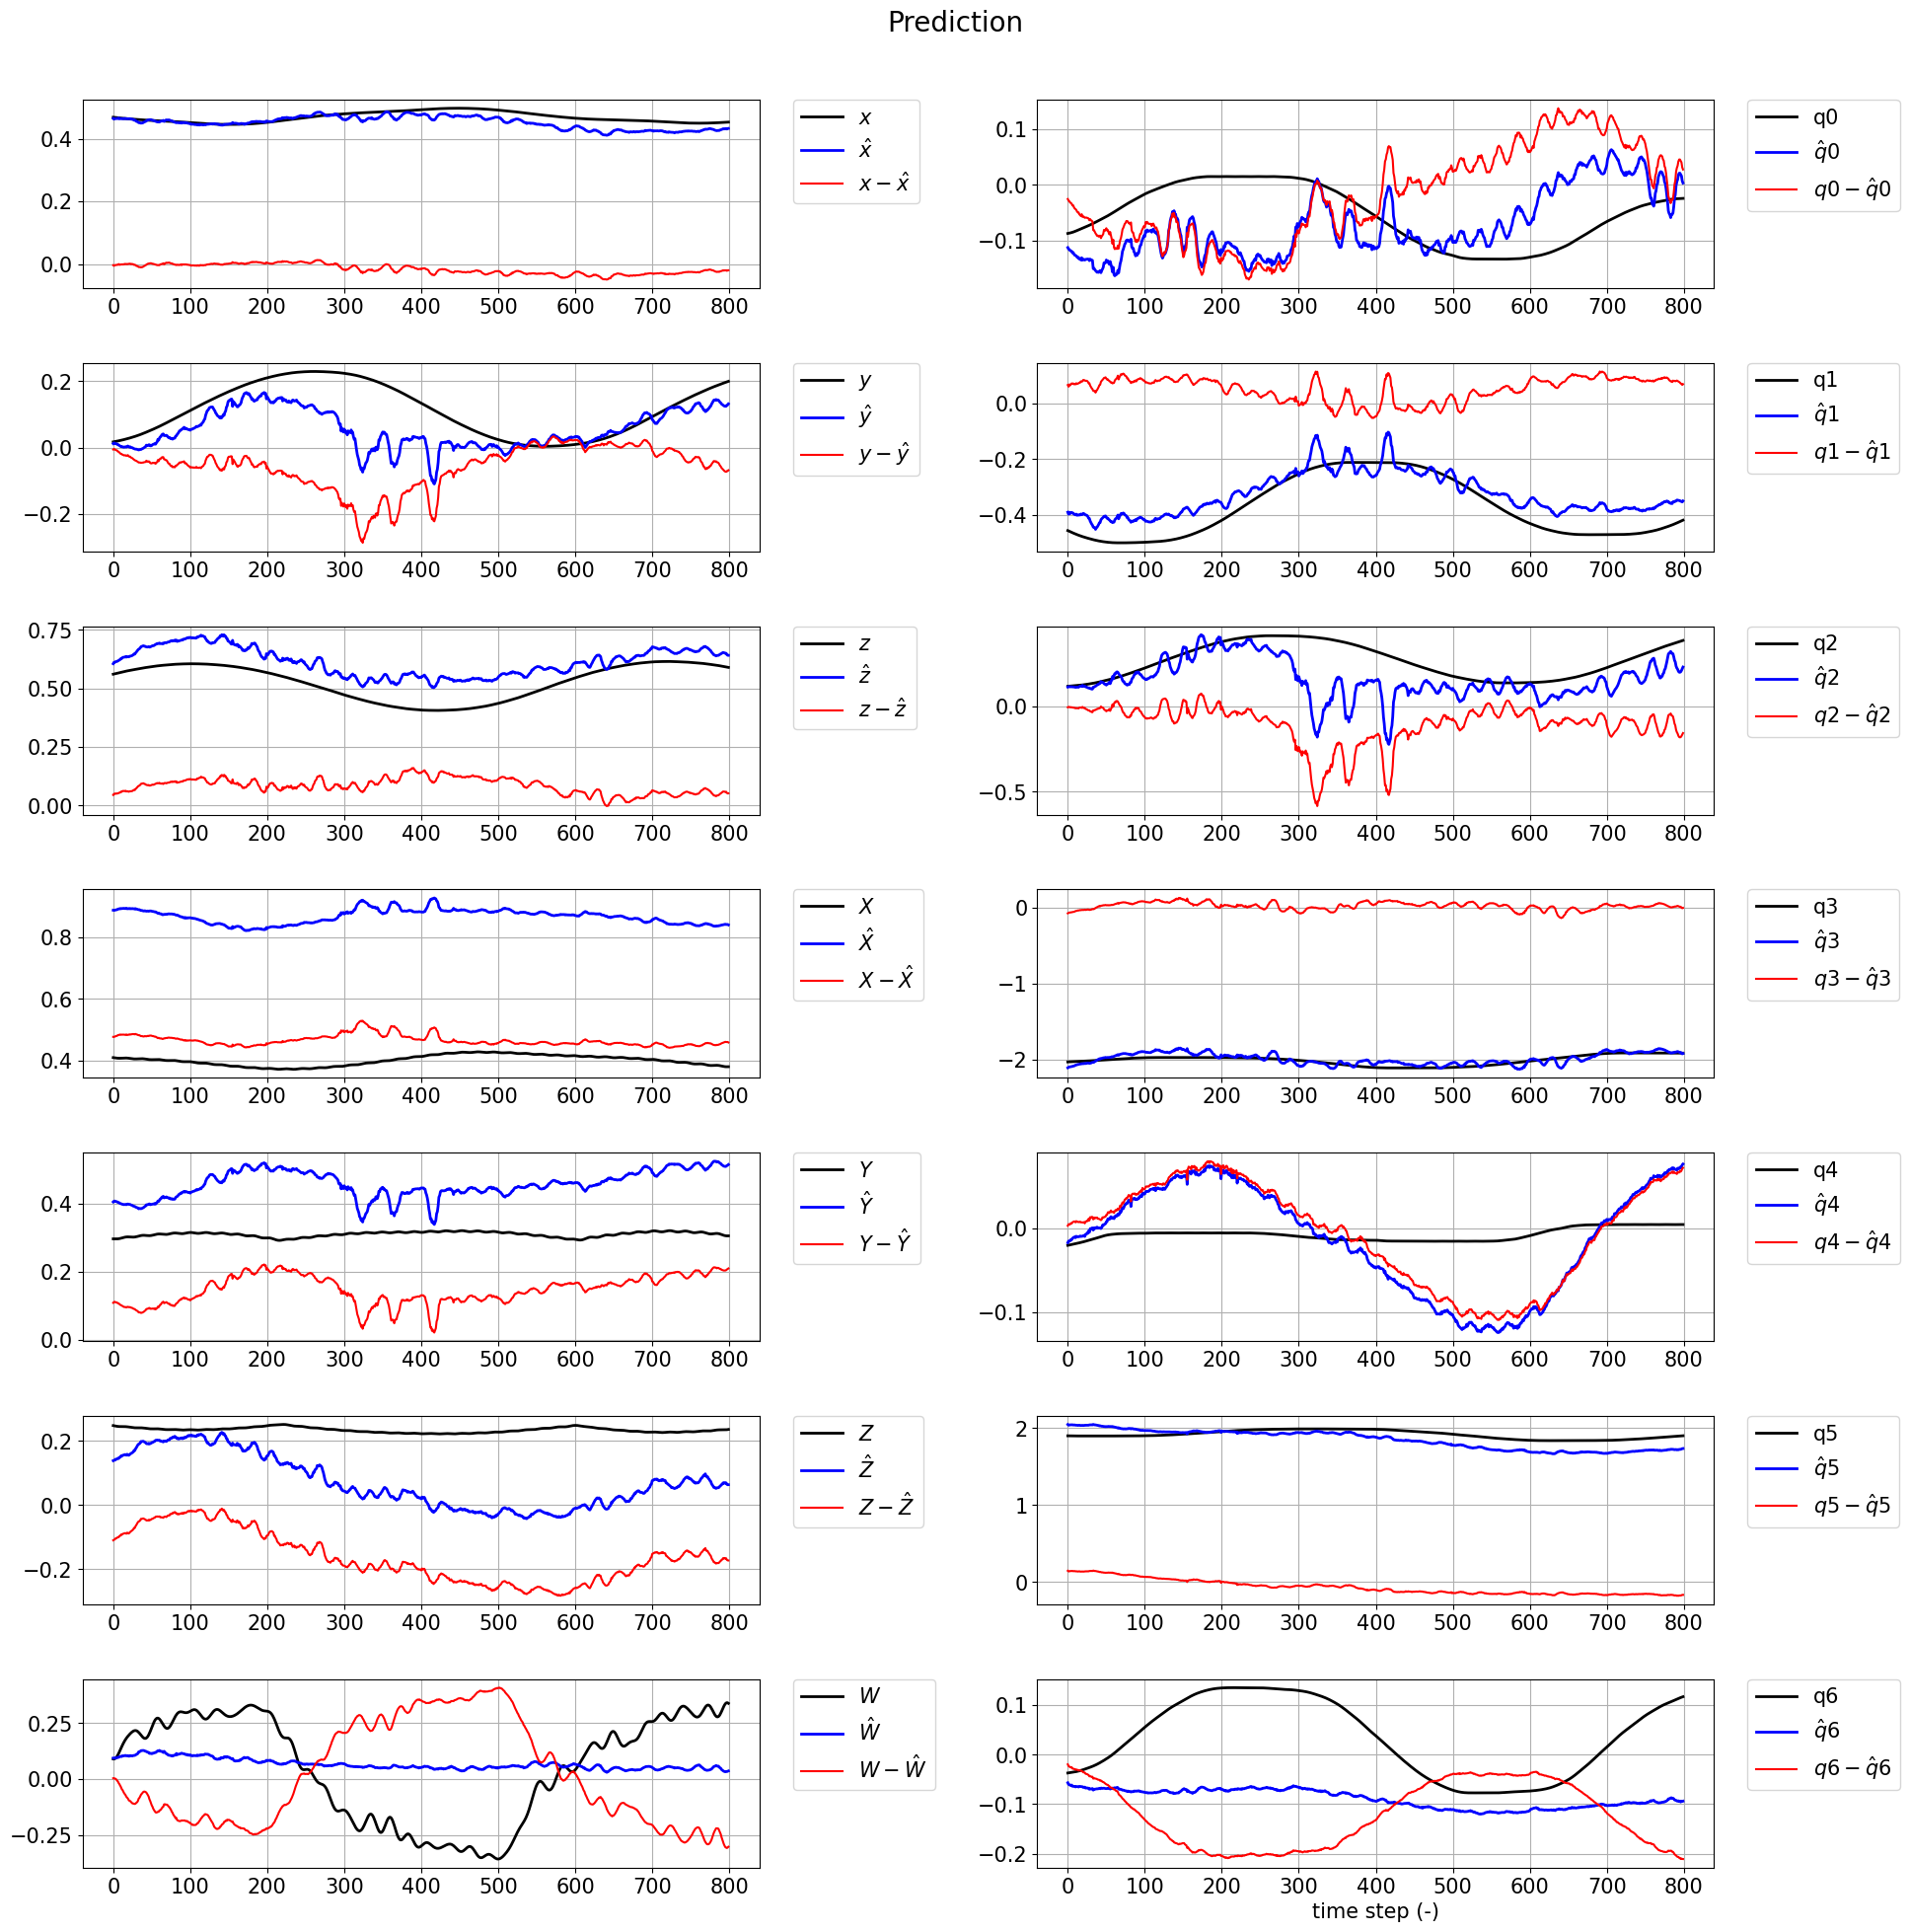

In [12]:
labels_coordinates = ["$x$","$y$","$z$" ,"$X$","$Y$","$Z$" ,"$W$","q0","q1","q2","q3","q4","q5","q6"]
labels_pred = ["$\hat x$","$\hat y$","$\hat z$","$\hat X$","$ \hat Y$","$\hat Z$" ,"$ \hat W$"
            ,"$ \hat q0$","$ \hat q1$","$ \hat q2$","$ \hat q3$","$ \hat q4$","$ \hat q5$","$ \hat q6$"]
labels_error = ["$x - \hat x$","$y - \hat y$","$z - \hat z$","$X - \hat X$","$ Y - \hat Y$",
                "$Z - \hat Z$" ,"$ W -  \hat W$","$ q0 -  \hat q0$","$ q1 -  \hat q1$","$ q2 -  \hat q2$"
                ,"$ q3 -  \hat q3$","$ q4 -  \hat q4$","$ q5 -  \hat q5$","$ q6 -  \hat q6$"]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

fig, axs = plt.subplots(int(ny/2), 2,figsize=(20, 20))
fig.suptitle('Prediction',size = 20,y = .99)
k = 0

t = np.arange(0,y_ground_truth.shape[0])

for j in range(int(2)):
    for i in range(int(ny/2)):
        axs[i,j].plot(t, y_ground_truth[:, k] ,'k', label=labels_coordinates[k],linewidth=2)
        axs[i,j].plot(t, y_predicted[:, k], 'b', label=labels_pred[k],linewidth=2)
        axs[i,j].plot(t, sim_error[:, k], 'r', label=labels_error[k])
        axs[i,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axs[i,j].grid(True)
        k=k+1

plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout( pad = 2)